In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [22]:
print(ratings)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


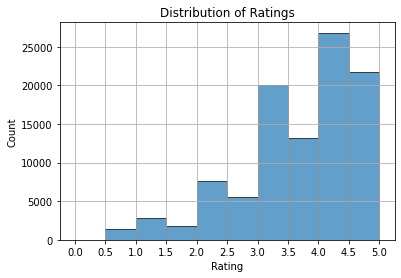

In [6]:
# Number of total ratings
total_ratings = ratings.shape[0]

# Number of videos in the database
num_videos = len(movies['movieId'].unique())

# Number of users
num_users = len(ratings['userId'].unique())

# Average number of ratings per user
avg_ratings_per_user = total_ratings / num_users

# Average number of ratings per video
avg_ratings_per_video = total_ratings / num_videos
# Distribution of ratings

# Distribution of ratings
rating_distribution = ratings['rating'].value_counts().sort_index()

# Creating bins for the distribution
bins = [i / 2 for i in range(0, 11)]  # Bins from 0 to 5 in intervals of 0.5

# Plotting distribution of ratings
plt.hist(ratings['rating'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(bins)
plt.grid(True)
plt.show()


In [7]:
movie_titles = dict(zip(movies['movieId'], movies['title']))


In [8]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')


In [9]:
from scipy.sparse import csr_matrix

def create_sparse(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


c:\Users\hawry\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz  # Number of stored values, including explicit 0s
sparsity = n_ratings / n_total
sparsity_p = round(sparsity * 100, 2)
print(f"Matrix sparsity: {sparsity_p}%")
n_ratings_per_user = X.getnnz(axis=1)


Matrix sparsity: 1.7%


In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(1, k + 1):  # Start from 1 to exclude the movie itself
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    return neighbour_ids


In [12]:
# Assuming you have loaded your dataset and created the necessary mappings

# Get the first movie ID
first_movie_id = movies['movieId'].iloc[0]

# Find similar movies to the first movie
similar_movies = find_similar_movies(first_movie_id, X, movie_mapper, movie_inv_mapper, k=10)

# Print the recommendations
print("Recommendations for the first movie:")
for movie_id in similar_movies:
    movie_title = movie_titles.get(movie_id, "Unknown")  # Get the title or return "Unknown" if not found
    print(movie_title)



Recommendations for the first movie:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [18]:
# 1.1
children_count = movies[movies['genres'].str.contains('Children')].shape[0]

print("Liczba filmów dla dzieci:", children_count)

Liczba filmów dla dzieci: 664


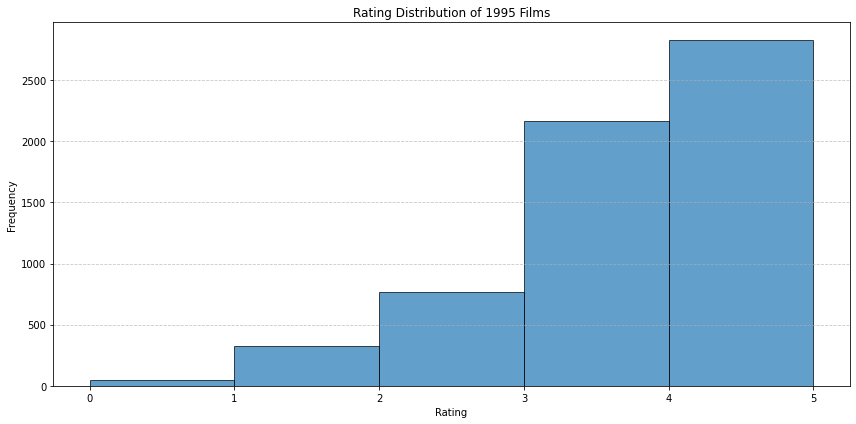

In [26]:

merged_data = pd.merge(movies, ratings, on='movieId')

# Extract year from title and filter for movies released in 1995
merged_data['year'] = merged_data['title'].str.extract(r'\((\d{4})\)')
movies_1995 = merged_data[merged_data['year'] == '1995']

# Group by movie and calculate rating distribution
rating_distribution = movies_1995.groupby('title')['rating'].value_counts(normalize=True).unstack().fillna(0)

#Plot rating distribution for 1995 films
plt.figure(figsize=(12, 6))
plt.hist(movies_1995['rating'], bins=range(0, 6, 1), edgecolor='black', alpha=0.7)
plt.title('Rating Distribution of 1995 Films')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [25]:
# Filter action movies
action_movies = movies[movies['genres'].str.contains('Action')]

# Merge action movies with ratings
action_ratings = pd.merge(action_movies, ratings, on='movieId')

# Calculate average rating of all action movies
average_rating_action = action_ratings['rating'].mean()

# Find the three highest rated movies
top_three_movies = action_ratings.groupby('title')['rating'].mean().nlargest(3)

print("Average rating of all action movies:", average_rating_action)
print("\nThree highest rated action movies:")
print(top_three_movies)

Average rating of all action movies: 3.447984331646809

Three highest rated action movies:
title
Alien Contamination (1980)                                         5.0
Assignment, The (1997)                                             5.0
Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)    5.0
Name: rating, dtype: float64
